Note 1: uses a much larger CNN

Note 2: uses data augmentation

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime # to calculate how much time does learn take per epoch

In [18]:
# examples: https://pytorch.org/docs/stable/torchvision/transforms.html
transformer_train = torchvision.transforms.Compose([
    # torchvision.transforms.ColorJitter(
    #   brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  # torchvision.transforms.RandomRotation(degrees=15),
  torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # torchvision.transforms.RandomPerspective()
  transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# behaves differently from MNIST / Fashion MNIST
# it is a Numpy array!
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [20]:
# we are working with color images now
train_dataset.data.shape

(50000, 32, 32, 3)

In [21]:
# behaves differently from MNIST / Fashion MNIST
# it is a list!
train_dataset.targets

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [22]:
# number of classes
K = len(set(train_dataset.targets))
print("number of classes:", K)

number of classes: 10


In [23]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [24]:
# the data transformer mapped the data to (0, 1)
# and also moved the color channel before height/width
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=1,
                                         shuffle=True)
for x, y in tmp_loader:
  print(x)
  print(x.shape)
  break

tensor([[[[0.3765, 0.4392, 0.5059,  ..., 0.3412, 0.3725, 0.3569],
          [0.3647, 0.3765, 0.4941,  ..., 0.3098, 0.3137, 0.3412],
          [0.3569, 0.3922, 0.4353,  ..., 0.3098, 0.3255, 0.3569],
          ...,
          [0.7725, 0.8196, 0.8941,  ..., 0.7882, 0.8431, 0.8902],
          [0.8824, 0.8980, 0.8980,  ..., 0.6118, 0.6902, 0.7490],
          [0.9059, 0.9137, 0.8941,  ..., 0.4745, 0.4706, 0.5569]],

         [[0.3725, 0.4353, 0.5059,  ..., 0.3216, 0.3529, 0.3373],
          [0.3608, 0.3765, 0.4941,  ..., 0.2941, 0.2941, 0.3216],
          [0.3529, 0.3882, 0.4314,  ..., 0.2902, 0.3059, 0.3373],
          ...,
          [0.7294, 0.7725, 0.8431,  ..., 0.7137, 0.7647, 0.8118],
          [0.8353, 0.8549, 0.8588,  ..., 0.5412, 0.6157, 0.6745],
          [0.8549, 0.8745, 0.8627,  ..., 0.4000, 0.3961, 0.4824]],

         [[0.2078, 0.2549, 0.3098,  ..., 0.1922, 0.2275, 0.2118],
          [0.1765, 0.1843, 0.2980,  ..., 0.1647, 0.1725, 0.1961],
          [0.1686, 0.2118, 0.2588,  ..., 0

In [25]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    # define the conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )
       
    # p = padding
    # Useful: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

    # Easy to calculate output
    # 32 > 16 > 8 > 4

    # define the linear layers
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

In [26]:
# Instantiate the model
model = CNN(K)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [29]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss

    train_loss = np.mean(train_loss) # a little misleading

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
    
  return train_losses, test_losses

In [30]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=80
)

Epoch 1/80, Train Loss: 1.2422,       Test Loss: 1.1699, Duration: 0:00:14.020468
Epoch 2/80, Train Loss: 0.8028,       Test Loss: 0.7977, Duration: 0:00:12.840446
Epoch 3/80, Train Loss: 0.6446,       Test Loss: 0.7743, Duration: 0:00:13.114227
Epoch 4/80, Train Loss: 0.5486,       Test Loss: 0.6387, Duration: 0:00:22.576927
Epoch 5/80, Train Loss: 0.4710,       Test Loss: 0.6532, Duration: 0:00:12.904626
Epoch 6/80, Train Loss: 0.4088,       Test Loss: 0.6423, Duration: 0:00:17.913208
Epoch 7/80, Train Loss: 0.3664,       Test Loss: 0.6349, Duration: 0:00:13.026930
Epoch 8/80, Train Loss: 0.3211,       Test Loss: 0.7148, Duration: 0:00:14.331248
Epoch 9/80, Train Loss: 0.2924,       Test Loss: 0.6505, Duration: 0:00:12.954512
Epoch 10/80, Train Loss: 0.2665,       Test Loss: 0.6507, Duration: 0:00:12.888506
Epoch 11/80, Train Loss: 0.2325,       Test Loss: 0.6948, Duration: 0:00:14.960626
Epoch 12/80, Train Loss: 0.2236,       Test Loss: 0.7322, Duration: 0:00:13.399899
Epoch 13/80, 

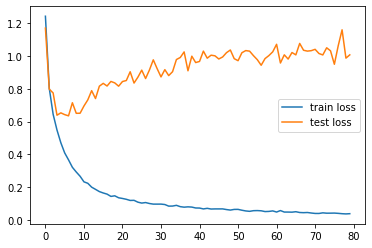

In [31]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()
# lot of overfitting overfitting

In [32]:
# Accuracy

model.eval() # model in evaluation mode
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max return both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max return both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9904, Test acc: 0.8415


In [33]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Prediceted label')
  plt.show()

Confusion matrix, without normalization
[[865  10  24   9  10   7   2  14  41  18]
 [ 10 930   1   4   1   3   0   1  13  37]
 [ 46   2 788  27  42  38  24  22   7   4]
 [ 22   3  44 724  33  93  34  32   8   7]
 [ 14   2  46  43 812  22  14  42   4   1]
 [  7   3  35 106  29 767   6  38   6   3]
 [  9   8  35  45  23  10 853   8   7   2]
 [  7   1  16  24  22  27   1 895   2   5]
 [ 46  17   8   4   2   2   3   4 904  10]
 [ 14  51   2   8   0   1   4   7  19 894]]


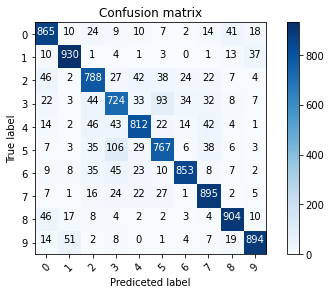

In [34]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get predictioin
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

# confussion matrix tells us for each label, how many predictions correspond 
# to that label

In [35]:
# Label mapping
labels = ''' airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split("\n")

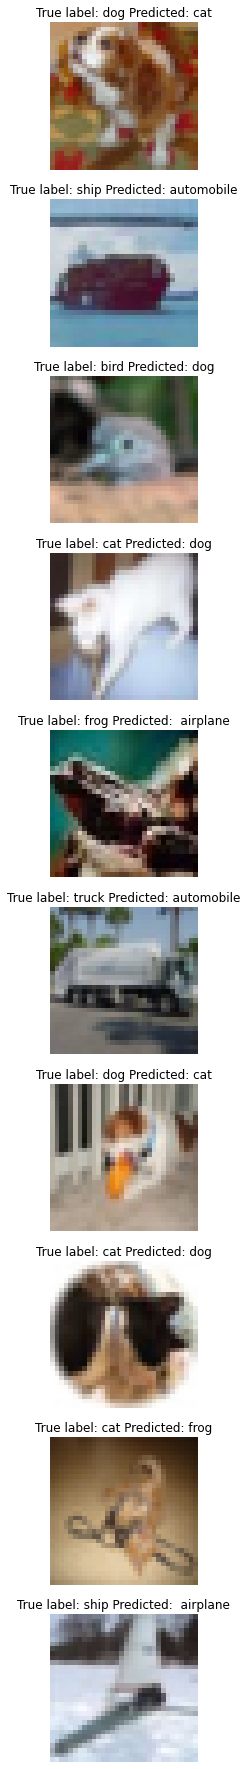

In [36]:
# Show some miniclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=False)
plt.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
  plt.subplot(10, 1, j+1)
  plt.axis('off')
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [37]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6